# Fitting

## Least_Squares Line Fitting

### B=Inverse(Transpose(X)X)Transpose(X)Y


[[285.  45.]
 [ 45.   9.]]
[1.85285463 2.55148021]


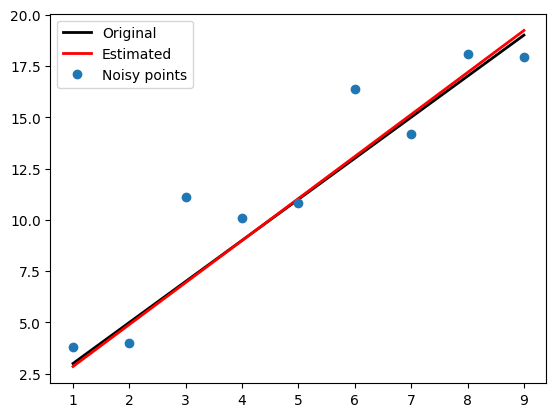

In [1]:
# Least-Squares
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

m = 2 # Line equation: y = m*x + c. m is the slope. c is the intercept.
c = 1
x = np.arange(1,10, 1)
n = 2.*np.random.randn(len(x)) # Noise
o = np.zeros(x.shape)
y = m*x + c + n + o # Noisy points confirming to a line

X = np.concatenate([x.reshape(len(x),1), np.ones((len(x), 1))], axis=1)
print(X.transpose()@X)
B = np.linalg.pinv(X.T@X)@X.T@y # Pseudo inverse computation
print(B)
mstar = B[0]
cstar = B[1]

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.legend(loc='best')

## Effect of Outlier

[[1017.25  114.5 ]
 [ 114.5    19.  ]]
[ 2.7922215 -2.8003388]


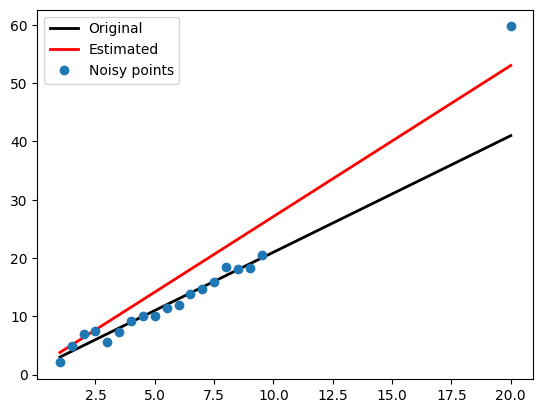

In [2]:
# Total Least Squares

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

m = 2
c = 1
x = np.arange(1,10, 0.5) # Un-corrupted x
# Append a number to x
x = np.append(x, 20)
n = np.random.randn(len(x))
o = np.zeros(x.shape)
o[-1] = 20 # Outliers
y = m*x + c + n + o

X = np.concatenate([x.reshape(len(x),1), np.ones((len(x), 1))], axis=1)
print(X.transpose()@X)
B = np.linalg.pinv(X.T@X)@X.T@y
print(B)
mstar = B[0]
cstar = B[1]

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.legend(loc='best')

## Total Least Square

In [5]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
# np.random.seed(0)
N = 100
t = np.random.uniform(0, 2*np.pi, N)

s = 1.
m, c = -1, 2
x = np.linspace(-12, 12, N) 
y = m*x + c + s*np.random.randn(N)
X_line = np.hstack((x.reshape(N,1), y.reshape(N,1))) 

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='Line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + c
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()


ImportError: cannot import name 'common_texification' from 'matplotlib.backends.backend_pgf' (C:\Users\nadil\AppData\Roaming\Python\Python312\site-packages\matplotlib\backends\backend_pgf.py)

## d = ax + by Parameterization

In [6]:
# Item 2: Line fitting with Total Least Squares
import math
N = X_line.shape[0]
X_ = X_line


U = X_ - np.mean(X_, axis=0)

# Eigenvector of 𝑈^𝑇𝑈 associated with the smallest eigenvalue
_, _, Vt = np.linalg.svd(np.transpose(U)@U)
a, b = Vt[-1, 0], Vt[-1, 1]
d = a*np.mean(X_[:,0]) + b*np.mean(X_[:,1])
best_model_line = np.array([a, b, d])

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_, label='Total least squares line')
y_ = m*x_ + c
plt.plot(x_, y_, label='Ground truth line')
plt.legend()

NameError: name 'X_line' is not defined

## Total Least Squares Line Fitting with scipy.optimize with RANSAC

In [7]:
# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
import math
N = X_line.shape[0]
X_ = X_line

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

NameError: name 'X_line' is not defined

## RANSAC

Samples [47 39]
[5.7 4.9] [4.67098826 5.1058277 ]
m, b: -0.5435492968146889 7.769219252110038
[9.47123619e+01 2.13392080e+01 2.06273941e+02 1.52556783e+00
 6.28275704e+01 6.69220431e+01 1.44085779e+02 1.08832407e+02
 2.29241040e+02 7.87198500e+01 1.89055782e+01 3.23259784e+02
 1.54675522e+02 2.55274728e+02 5.60164823e+02 2.71476688e+02
 2.30657966e+02 2.10086302e+02 1.76876670e+02 2.76889724e+02
 2.96000136e+02 8.18947412e+01 6.59682984e+02 4.48355453e+02
 3.53780832e+02 4.48887904e+02 3.86174561e+02 2.09404487e+02
 5.74120650e+02 6.04387600e+02 6.60839515e+02 1.99801472e+02
 2.95706166e+02 2.83789916e+02 4.58903070e+02 3.20335293e+02
 1.92157825e+02 4.83765733e+02 1.45473927e+02 2.41443071e+02
 4.28691995e+02 5.52592608e+02 2.80660789e+02 6.49756202e+02
 1.01386345e+02 1.04172385e+02 1.67070130e+02 2.41443071e+02
 3.11965468e+02 8.88633194e+02 9.15782157e+02 1.34177592e+03
 5.98925659e+02 4.57170578e+02 2.50507018e+02 3.26012100e+02
 7.67061526e+02 8.61004593e+02 1.18145731e+03 5.6463

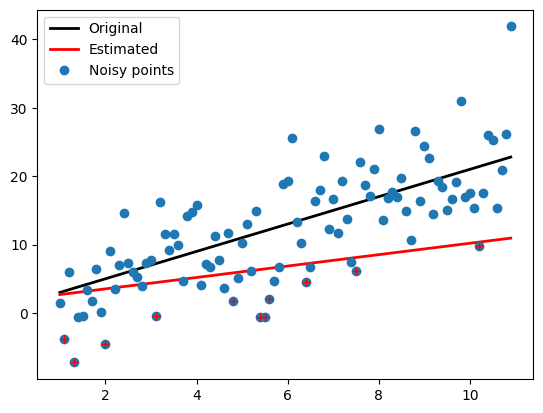

In [8]:
# RANSAC

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

m = 2
c = 1
xo = np.arange(1,11, 0.1) # Un-corrupted x
mu, sigma = 0, 5 # mean and standard deviation
#x = xo + np.random.normal(mu, sigma, len(xo)) # noisy x
x = xo
n = np.random.normal(mu, sigma, len(xo))
o = np.zeros(x.shape)
o[-1] = 20 # Outliers
y = m*x + c + n + o

def line(x,y):
    m = (y[1] - y[0])/(x[1] - x[0])
    b = y[0] - m*x[0]
    print("m, b:", m, b)
    return m, -1, b

def distance(parameters, x, y):
    a = parameters[0]
    b = parameters[1]
    d = parameters[2]
    return (a*x + b*y - d)**2


thresh = 10
s = 2
loop = True 
consensus = []
while loop:
    samples = np.random.choice(len(x), 2, replace=False)
    print("Samples", samples)
    xs = x[samples]
    ys = y[samples]
    print(xs,ys)
    parameters = line(xs,ys)
    print(distance(parameters, x, y) )
    consensus =  distance(parameters, x, y) < thresh
    print('Consensus: ', consensus)
    print("Lenght:", sum(consensus))
    if sum(consensus) >= 2:
        loop = False
    

xc = x[consensus]
yc = y[consensus]
print("xc:", xc)
print("yc", yc)
X = np.concatenate([xc.reshape(len(xc),1), np.ones((len(xc), 1))], axis=1)
print(X.transpose()@X)
B = np.linalg.pinv(X.T@X)@X.T@yc
print(B)
mstar = B[0]
cstar = B[1]

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.plot(xc, yc, '+', color='r')
plt.legend(loc='best')

## Hough Lines

In [9]:
# Hough Lines
import cv2 as cv
import numpy as np
img = cv.imread('images/sudoku.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,50,100,apertureSize = 3)
lines = cv.HoughLines(edges,1,np.pi/180,200)

# Plotting
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    
cv.namedWindow("Image", cv.WINDOW_NORMAL)
cv.imshow("Image", img)
cv.waitKey()
cv.imshow("Image", edges)
cv.waitKey()
cv.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Hough Circles

In [ ]:
# Hough Circles
import cv2 as cv
import numpy as np

img = cv.imread('images/coins.jpg',0)
img = cv.medianBlur(img,7)
img = cv.GaussianBlur(img, (7,7), 3)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT,1,40, param1=50,param2=30,minRadius=20,maxRadius=50)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

cv.imshow('Detected Circles',img)
cv.waitKey(0)
cv.imshow('Detected Circles',cimg)
cv.waitKey(0)
cv.destroyAllWindows()

## Generalized Hough Transform
https://www.youtube.com/watch?v=_mGxmZWs9Zw

In [ ]:
# Generalized Hough Transform

import cv2 as cv
import numpy as np
im = cv.imread('images/pic1.png', cv.IMREAD_REDUCED_GRAYSCALE_2)
templ  = cv.imread('images/templ.png', cv.IMREAD_REDUCED_GRAYSCALE_2)

# Canny edge detection
im_edges = cv.Canny(im, 50, 250)
templ_edges = cv.Canny(templ, 50, 250)

alg = cv.createGeneralizedHoughGuil()
alg.setTemplate(templ_edges)

# Canny thresholds not reuired as 
# alg.setCannyLowThresh(50)
# alg.setCannyHighThresh(250)

# Votes thresholds (to be carefully selected)
alg.setAngleThresh(100000)
alg.setScaleThresh(40000)
alg.setPosThresh(1000)

# alg.setAngleThresh(400000)
# alg.setScaleThresh(10000)
# alg.setPosThresh(100)

alg.setAngleStep(1)
alg.setScaleStep(0.1)
alg.setMinScale(0.9)       
alg.setMaxScale(1.1)

positions, votes = alg.detect(im_edges) # Actual detection

out = cv.cvtColor(im, cv.COLOR_BAYER_BG2BGR)
for x, y, scale, orientation in positions[0]:
    halfHeight = templ.shape[0] / 2. * scale
    halfWidth = templ.shape[1]/ 2. * scale
    p1 = (int(x - halfWidth), int(y - halfHeight))
    p2 = (int(x + halfWidth), int(y + halfHeight))
    print("x = {}, y = {}, scale = {}, orientation = {}, p1 = {}, p2 = {}".format(x, y, scale, orientation, p1, p2))
    cv.rectangle(out, p1, p2, (0,0,255))

cv.namedWindow('Image')
cv.imshow('Image', templ)
cv.waitKey(0)
cv.imshow('Image', im)
cv.waitKey(0)
cv.imshow('Image', out)
cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
votes